In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import missingno as msno
from pandas.plotting import scatter_matrix
import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train=pd.read_csv('../input/titanic/train.csv')
test=pd.read_csv('../input/titanic/test.csv')

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


# 1. Data Description


# Variable	Definition	Key
# survival	Survival	0 = No, 1 = Yes
# pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
# sex	Sex	
# Age	Age in years	
# sibsp	# of siblings / spouses aboard the Titanic	
# parch	# of parents / children aboard the Titanic	
# ticket	Ticket number	
# fare	Passenger fare	
# cabin	Cabin number	
# embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

# 1. Check Missing Values

In [3]:
print(train.info())
print('_+_+_+_&*_*_*_*_*_')
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
_+_+_+_&*_*_*_*_*_
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null 

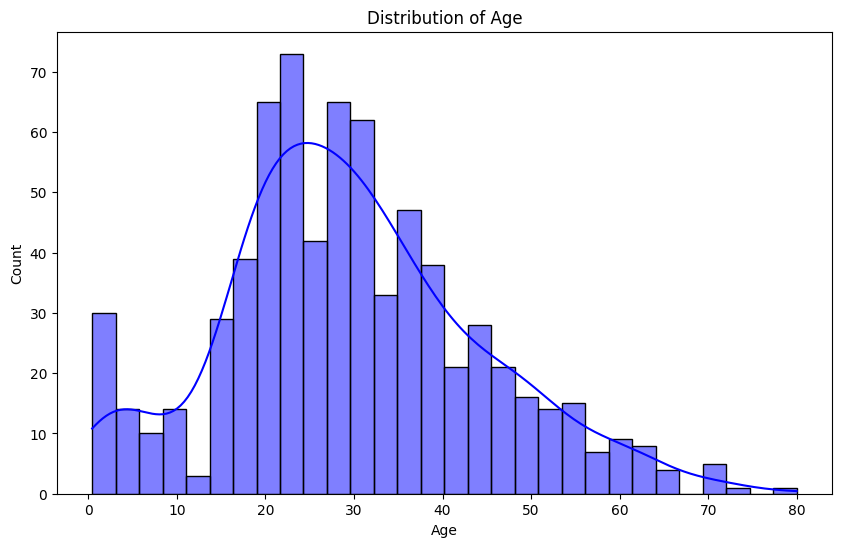

In [4]:
# Visualize the distribution of 'Age'
plt.figure(figsize=(10, 6))
sns.histplot(train['Age'].dropna(), bins=30, kde=True, color='blue')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

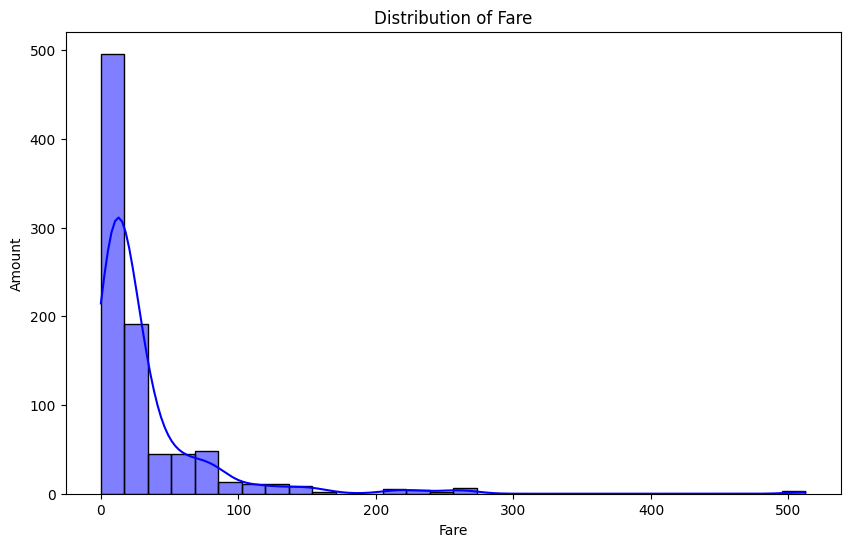

In [5]:
# Visualize the distribution of 'Age'
plt.figure(figsize=(10, 6))
sns.histplot(train['Fare'].dropna(), bins=30, kde=True, color='blue')
plt.title('Distribution of Fare')
plt.xlabel('Fare')
plt.ylabel('Amount')
plt.show()

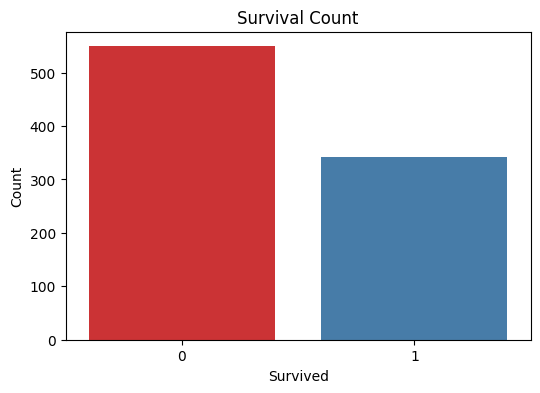

In [6]:
# Visualize the survival count
plt.figure(figsize=(6, 4))
sns.countplot(x='Survived', data=train, palette='Set1')
plt.title('Survival Count')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.show()

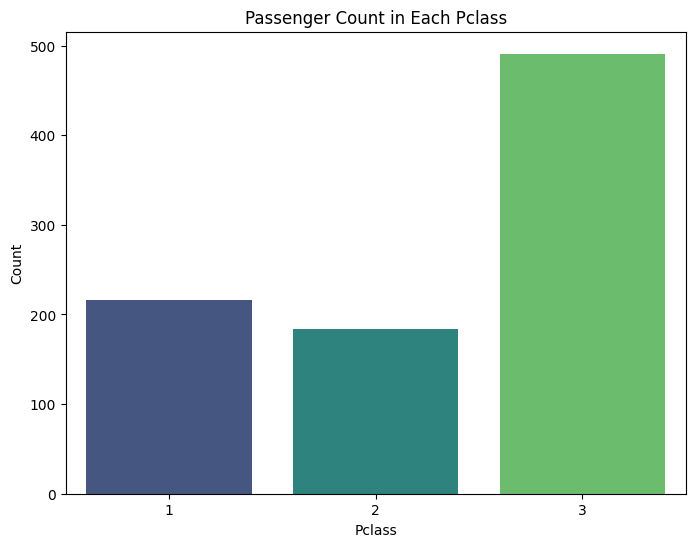

In [7]:
# Visualize the count of passengers in each Pclass
plt.figure(figsize=(8, 6))
sns.countplot(x='Pclass', data=train, palette='viridis')
plt.title('Passenger Count in Each Pclass')
plt.xlabel('Pclass')
plt.ylabel('Count')
plt.show()

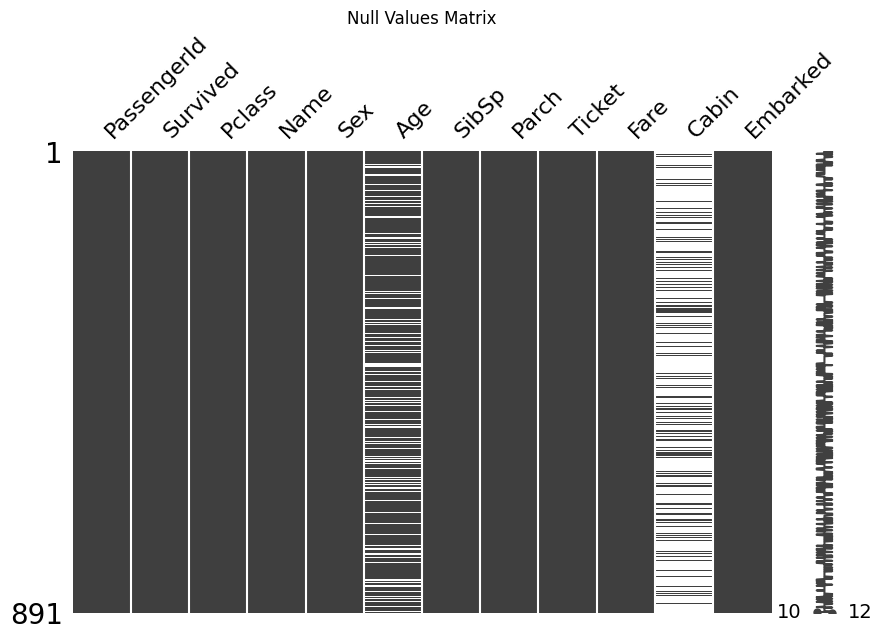

In [8]:
# Visualize null values using missingno matrix
msno.matrix(train, figsize=(10, 6))
plt.title('Null Values Matrix')
plt.show()

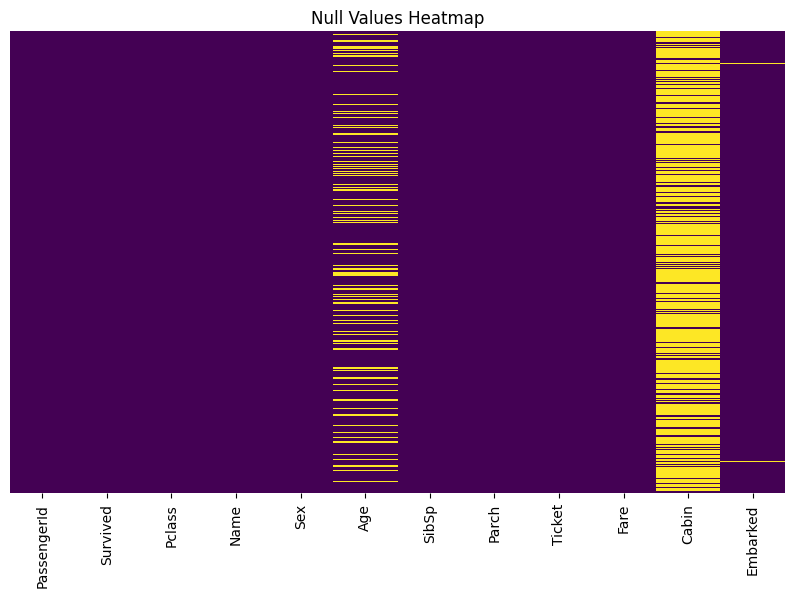

In [9]:
# Create a heatmap of null values
plt.figure(figsize=(10, 6))
sns.heatmap(train.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title('Null Values Heatmap')
plt.show()

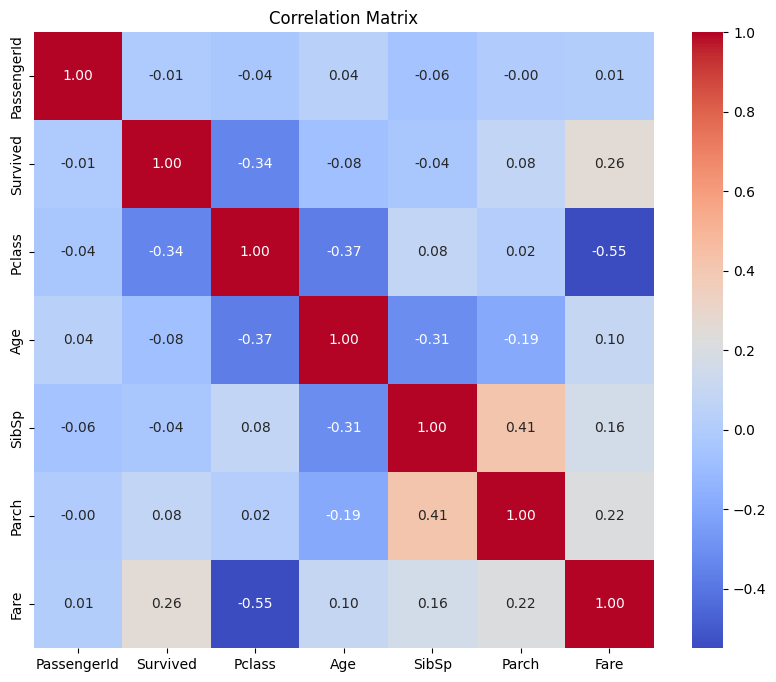

In [10]:
# Visualize the correlation between numeric features
numeric_columns = train.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_columns.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [11]:
sum(train['Survived'].isna())

0

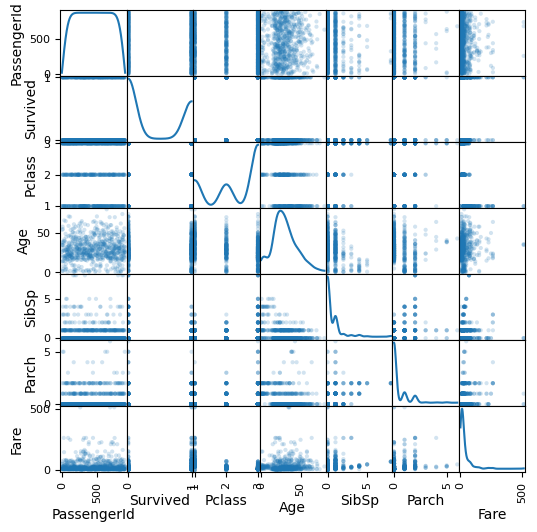

In [12]:
scatter_matrix(train, alpha=0.2, figsize=(6, 6), diagonal='kde')
plt.show()

# 2. Handling Missing Values and Adding New Features¶

In [13]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [14]:
#Train set 
#Handling Ticket type
train['T_type'] = train['Ticket'].apply(lambda x: x[0:3])
train['T_type'] = train['T_type'].astype('category')
train['T_type'] = train['T_type'].cat.codes
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)




#Test set 
#Handling Ticket type
test['T_type'] = test['Ticket'].apply(lambda x: x[0:3])
test['T_type'] = test['T_type'].astype('category')
test['T_type'] = test['T_type'].cat.codes

# Feature that tells whether a passenger had a cabin on the Titanic
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)


train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,T_type,Has_Cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,124,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,137,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,148,0


In [15]:
# combining all data
full_data = [train, test]

# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna(dataset['Embarked'].mode()[0])
    
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  T_type       891 non-null    int16  
 13  Has_Cabin    891 non-null    int64  
dtypes: float64(2), int16(1), int64(6), object(5)
memory usage: 92.4+ KB


In [16]:
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
    
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
# Define the bins and labels for Fare column
bins = [0, 7.91, 14.45, 31, 1000]
labels = [1, 2, 3, 4]

# Use pd.cut to scale the 'Fare' column
for dataset in full_data:
    dataset['Fare'] = pd.cut(dataset['Fare'], bins=bins, labels=labels, right=False).astype(int)

# Create a New feature Categorical Age
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
# Define the bins and labels for AGE column
bins = [0, 15, 30, 45, 60, 150]
labels = [1, 2, 3, 4, 5]

# Use pd.cut to scale the 'Age' column
for dataset in full_data:
    dataset['Age'] = pd.cut(dataset['Age'], bins=bins, labels=labels, right=False).astype(int)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
# Group all non-common titles into one single grouping "Rare"
rareTitles = ['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(rareTitles, 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

#mapping data
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,T_type,Has_Cabin,FamilySize,IsAlone,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,2,1,0,A/5 21171,1,NaN,0,124,0,2,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,3,1,0,PC 17599,4,C85,1,137,1,2,0,3
2,3,1,3,"Heikkinen, Miss. Laina",0,2,0,0,STON/O2. 3101282,2,NaN,0,148,0,1,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,3,1,0,113803,4,C123,0,3,1,2,0,3
4,5,0,3,"Allen, Mr. William Henry",1,3,0,0,373450,2,NaN,0,97,0,1,1,1


In [17]:
testPassengerIds = test.PassengerId
testPassengerIds

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

In [18]:
survived_train = train['Survived']
train = train.drop(['Survived'], axis = 1)
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)
print(train.info())
print('_+_+_+_&*_*_*_*_*_')
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Pclass      891 non-null    int64
 1   Sex         891 non-null    int64
 2   Age         891 non-null    int64
 3   SibSp       891 non-null    int64
 4   Parch       891 non-null    int64
 5   Fare        891 non-null    int64
 6   Embarked    891 non-null    int64
 7   T_type      891 non-null    int16
 8   Has_Cabin   891 non-null    int64
 9   FamilySize  891 non-null    int64
 10  IsAlone     891 non-null    int64
 11  Title       891 non-null    int64
dtypes: int16(1), int64(11)
memory usage: 78.4 KB
None
_+_+_+_&*_*_*_*_*_
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Pclass      418 non-null    int64
 1   Sex         418 non-null    int64
 2   Age      

# 3.Using different Models

<Axes: title={'center': 'Correlation of Features'}>

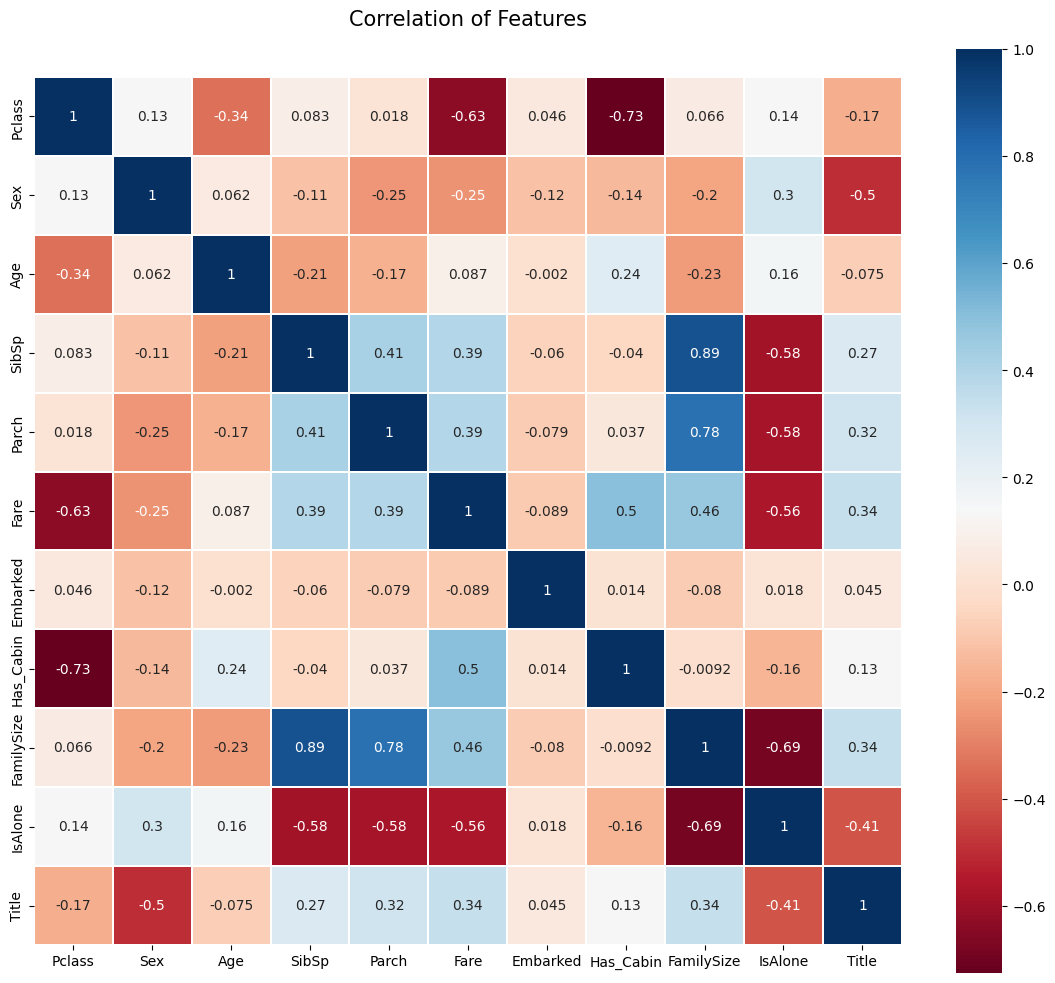

In [19]:
numeric_columns = train.select_dtypes(include=['int64', 'float64'])
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(numeric_columns.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

# 3.1.Decision Tree Classifier  [Predicted(%72)]

In [20]:
# from sklearn.tree import DecisionTreeClassifier

# # Initialize a Decision Tree Classifier
# model = DecisionTreeClassifier()

# # Train the model
# model.fit(train, survived_train)

# # Make predictions on the test set
# predictions = model.predict(test)
# predictions

# 3.2.Logistic Regression [Predicted(%77)]

In [21]:
# from sklearn.linear_model import LogisticRegression

# #adding Logistic regeression model
# logmodel = LogisticRegression(max_iter=10000)

# #training model with the train data
# logmodel.fit(train, survived_train)

# #Try to get the pridiction with data
# predictions = logmodel.predict(test)
# predictions

# 3.3.XGBosst Classifier [Predicted(%00)]

In [22]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(train, survived_train)

#Try to get the pridiction from the train data
predictions = gbm.predict(test)
predictions

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,

# 4.Submit Answers

In [23]:
df_predictions = pd.DataFrame()
df_predictions['PassengerId'] = pd.Series(testPassengerIds.T.values)
df_predictions['Survived'] = pd.Series(predictions)
df_predictions.to_csv("3rd_ClassicTitanic_Attempt.csv", sep=',', index=False)
df_predictions.head(15)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
